In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header = None)



In [15]:
data.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [14]:
data.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
data.corr()

,0,1,2,3
0,1.000000,-0.109369,0.871754,0.817954
1,-0.109369,1.000000,-0.420516,-0.356544
2,0.871754,-0.420516,1.000000,0.962757
3,0.817954,-0.356544,0.962757,1.000000


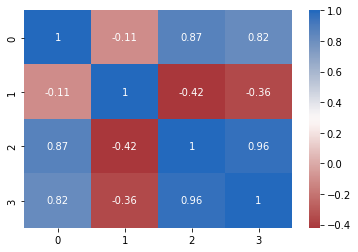

In [13]:
sns.heatmap(data.corr(), annot = True, cmap = 'vlag_r',) 

There is some positive correlation between 0,2,3 and between 2,3

In [17]:
dataNP = data.to_numpy()
A = dataNP[:, :4].T.astype(np.float64)
labels = dataNP[:,4]
groups = ('Iris-setosa','Iris-versicolor','Iris-virginica')

A.shape, labels.shape

((4, 150), (150,))

In [22]:
[print("Number of samples for ",groups[i] , ": ",A[:,labels==groups[i]].shape[1]) for i in range(3)] 

Number of samples for  Iris-setosa :  50
Number of samples for  Iris-versicolor :  50
Number of samples for  Iris-virginica :  50


[None, None, None]

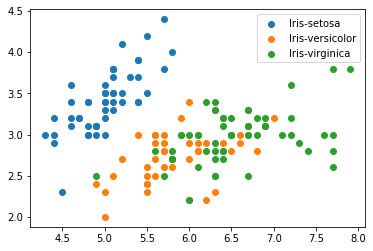

In [58]:
[plt.scatter(A[0,labels==groups[i]],A[1,labels==groups[i]],label=groups[i]) for i in range(3)] 
plt.legend()

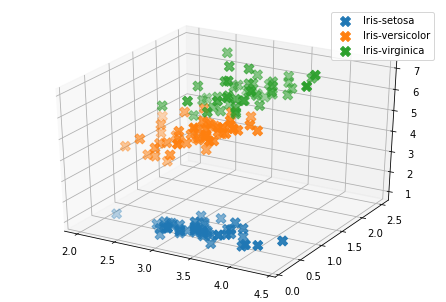

In [48]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
[ax.scatter(A[1,labels==groups[i]],A[3,labels==groups[i]],A[2,labels==groups[i]],label=groups[i],marker = "X", s=100) for i in range(3)] 
#ax.view_init(20,25)
ax.legend()

Text(0.5, 1.0, 'explained variance')

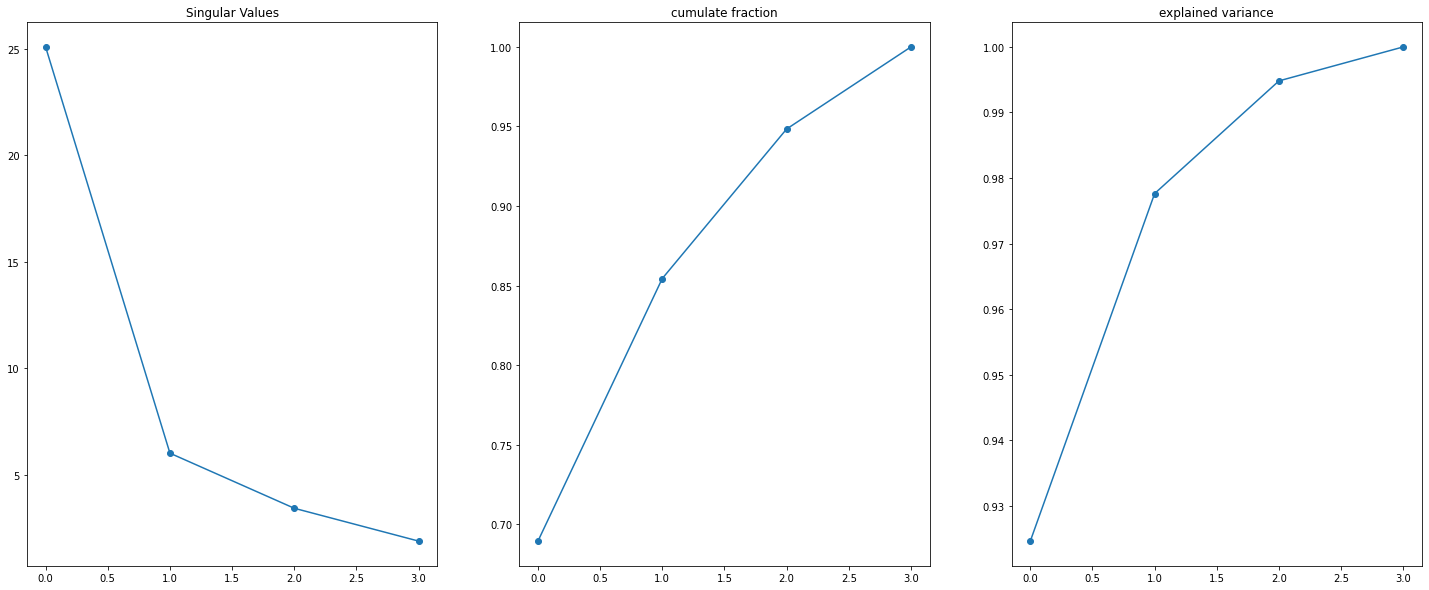

In [37]:
Anorm = A - np.mean(A,axis=1)[:,None]
U, s, VT = np.linalg.svd(Anorm, full_matrices=False)

fig, axs = plt.subplots(1,3, figsize = (25,10))
axs[0].plot(s, 'o-')
axs[0].set_title('Singular Values')
axs[1].plot(np.cumsum(s)/np.sum(s), 'o-')
axs[1].set_title('cumulate fraction')
axs[2].plot(np.cumsum(s**2)/np.sum(s**2), 'o-')
axs[2].set_title('explained variance')

In [38]:
U.shape , s.shape, VT.shape

((4, 4), (4,), (4, 150))

In [56]:
Phi = U.T @ Anorm
Phi.shape
#principal direction U[:,i] ==>> U[:,0].T(1x4) x Anorm(4x150) ==> (1x150)

(4, 150)

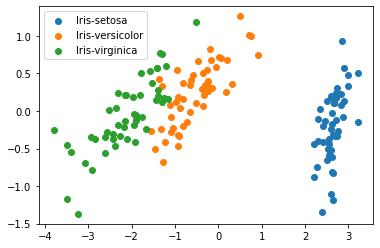

In [59]:
pc1 = Phi[0,:]
pc2 = Phi[1,:]
[plt.scatter(pc1[labels==groups[i]],pc2[labels==groups[i]],label=groups[i]) for i in range(3)] 
plt.legend()

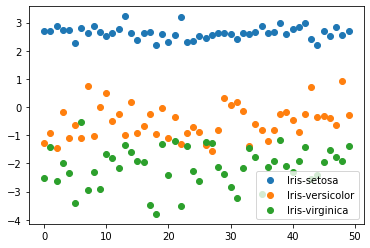

In [70]:
[plt.scatter([a for a in range(50)],pc1[labels==groups[i]],label=groups[i]) for i in range(3)] 
plt.legend()

In [147]:
def classifier(pc1):
  return np.array(['Iris-setosa' if pc1[i]>=1.5 else 'Iris-virginica' if pc1[i]<=-1.3  else 'Iris-versicolor'  for i in range(len(pc1))])

np.random.seed(0)
index = np.random.choice(pc1.shape[0],pc1.shape[0], replace=False)
y_pred = classifier(pc1)

TP=0
CM = np.zeros((3,3))
for i in range(3):
  CM[i,i] = np.sum(np.logical_and(y_pred == groups[i], labels== groups[i]))
  j=i+1 if (i % 2)!= 0 else i-1
  CM[i,j] = np.sum(np.logical_and(y_pred == groups[i], labels== groups[j]))
  TP += CM[i,i]
  
accuracy = TP / np.sum(CM)
print("Accuracy of prediction on pc1: %1.3f" % accuracy)
CM #prediction on the rows, true label on the columns

Accuracy of prediction on pc1: 0.933


array([[50.,  0.,  0.],
       [ 0., 46.,  6.],
       [ 0.,  4., 44.]])

#ANN and SGD

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import time

**Mapping of the output in One-Hot encoding**

In [111]:
y_OH = np.zeros((3, 150)) #20000 labels.shape, 10 digits
for i in range(3):
  y_OH[i,labels==groups[i]] = 1 
y_OH.shape


(3, 150)

In [112]:
def initialize_params(layers_size):
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size)-1):
    W = np.random.randn(layers_size[i+1],layers_size[i]) * np.sqrt(2 / (layers_size[i+1] + layers_size[i]))
    b = np.zeros((layers_size[i+1],1))
    params.append(W)
    params.append(b)

  return params
layers_size = [4,8,8,3]
#initialize_params(layers_size)

In [118]:
def ANN(x,params):
  weights = params[0::2]
  biases = params[1::2]
  num_layers= len(biases)+1
  layer = x #x.T(150x4) , x(4x150)
  for i in range(num_layers-1):
    layer = weights[i]@layer - biases[i]
    if i < num_layers - 1 : 
      layer = jnp.tanh(layer)
  softmax = jnp.exp(layer)/jnp.sum(jnp.exp(layer), axis=0) # sum wrt the first axis(for each sample)
  return softmax

params = initialize_params(layers_size)
y = ANN(A, params)

In [148]:
def MSE(x, y, params):
  return jnp.mean(jnp.square(y - ANN(x, params)))

def cross_entropy(x, y, params):
  y_appr = ANN(x, params)
  return - jnp.mean(jnp.sum(y*jnp.log(y_appr), axis=0))

def accuracy(x, y, params):
  y_appr = jnp.argmax(ANN(x, params), axis = 0)
  y      = jnp.argmax(y, axis = 0)
  return jnp.mean(y == y_appr)  

print('MSE:       %f' % MSE(A, y_OH, params))
print('X entropy: %f' % cross_entropy(A, y_OH, params))
print('accuracy:  %f' % accuracy(A, y_OH, params))

MSE:       0.037399
X entropy: 0.300286
accuracy:  0.960000


In [149]:
from IPython import display

class Callback:
  def __init__(self, refresh_rate = 250):
    self.refresh_rate = refresh_rate
    self.fig, self.axs = plt.subplots(1, figsize=(16,8))
    self.epoch = 0
    self.__call__(-1)

  def __call__(self, epoch):
    self.epoch = epoch
    if (epoch + 1) % self.refresh_rate == 0:
      self.draw()
      display.clear_output(wait=True)
      display.display(plt.gcf())
      time.sleep(1e-16)

  def draw(self):
    if self.epoch > 0:
      self.axs.clear()
      epochs = np.arange(1,len(history_train_Xen) + 1)
      self.axs.loglog(epochs, history_train_Xen, label = 'train_Xen')
      self.axs.loglog(epochs, history_valid_Xen, label = 'valid_Xen')
      self.axs.loglog(epochs, history_valid_MSE, label = 'valid_MSE')
      self.axs.loglog(epochs, history_valid_acc, label = 'valid_acc')

      self.axs.legend()
      self.axs.set_title('epoch %d - accuracy %0.1f%%' % (self.epoch + 1, 100*history_valid_acc[-1]))

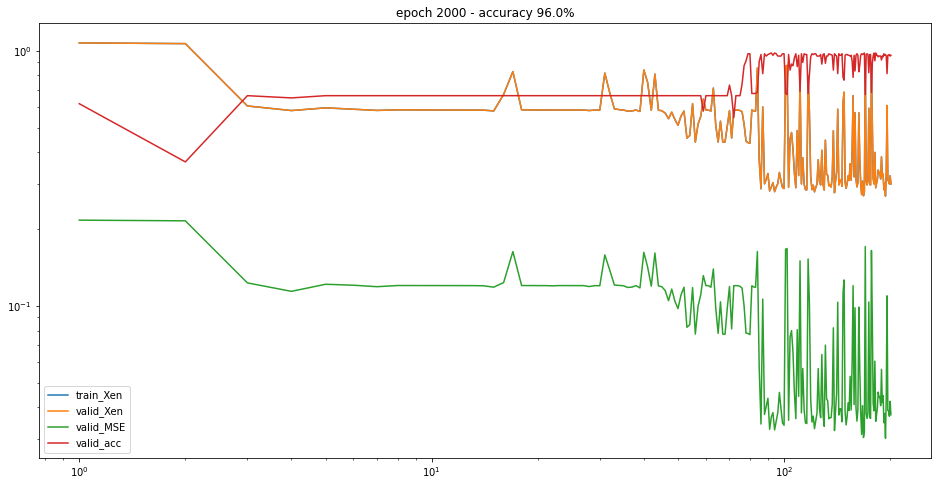

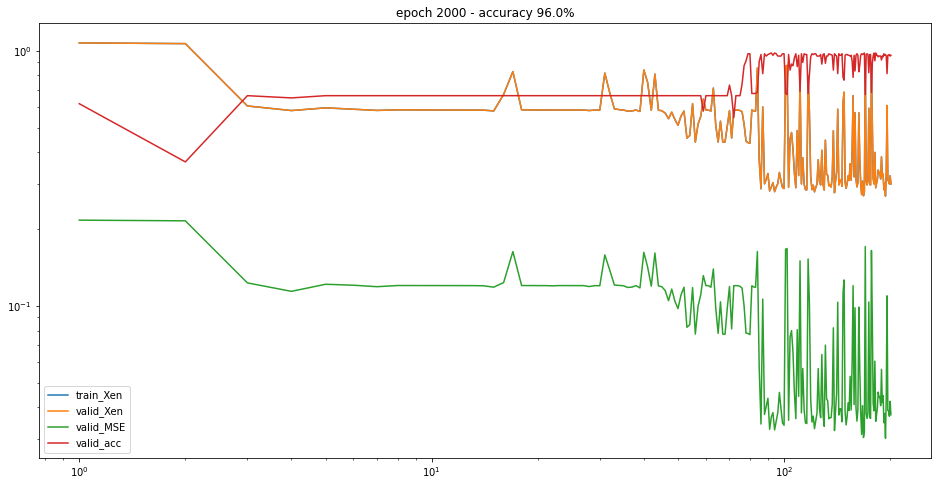

In [150]:
# Hyperparameters
layers_size = [4, 8, 8, 3]
# Training options
lr_min = 5e-2
lr_max = 2e-2
lr_decay = 2000

num_epochs = 2000
batch_size = 10
learning_rate = 2e-3
decay_rate = .9
delta = 1e-7

history_train_Xen = list()
history_valid_Xen = list()
history_valid_MSE = list()
history_valid_acc = list()

grad_jit = jax.jit(jax.grad(cross_entropy, argnums = 2))
loss_Xen_jit = jax.jit(cross_entropy)
loss_MSE_jit = jax.jit(MSE)
loss_acc_jit = jax.jit(accuracy)

params = initialize_params(layers_size)

def store_losses():
  history_train_Xen.append(loss_Xen_jit(A, y_OH, params))
  history_valid_Xen.append(loss_Xen_jit(A, y_OH, params))
  history_valid_MSE.append(loss_MSE_jit(A, y_OH, params))
  history_valid_acc.append(loss_acc_jit(A, y_OH, params))

store_losses()
cb = Callback()
cumulate_grad = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
  learning_rate = max(lr_min, lr_max*(1-epoch/lr_decay))
  idxs = np.random.choice(A.shape[1], batch_size)
  g = grad_jit(A[:,idxs], y_OH[:,idxs], params)
  for i in range(len(params)):
    cumulate_grad[i] = decay_rate*cumulate_grad[i] + (1 - decay_rate) * g[i]**2
    params[i] -= learning_rate / (delta + jnp.sqrt(cumulate_grad[i])) * g[i]
  if epoch % 10 == 9: store_losses()
  cb(epoch)
cb.draw()

In [153]:
print("Accuracy of prediction of the ANN: %1.3f" % history_valid_acc[-1])

Accuracy of prediction of the ANN: 0.960


#Secondo exercise on SGD

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import time

m = 100
noise = 1.0
coeff_exact = np.array([5.0, 1.0])
np.random.seed(0)
X = np.c_[[1]*100, 13.5 * np.random.rand(m, 1)]
y = X @ coeff_exact + noise * np.random.randn(m)

In [159]:
X.shape, y.shape

((100, 2), (100,))

In [179]:
def model(x,params):
  return x @ params

np.random.seed(0)
params = np.random.randn(2)
model(X,params)

array([4.72881002, 5.62759278, 5.02025383, 4.70757795, 4.05268739,
       5.25325135, 4.12795198, 6.58151917, 6.96987645, 3.83545033,
       6.04104784, 4.62120739, 4.83269854, 6.7642386 , 2.14779782,
       2.23473548, 1.8732746 , 6.26196659, 5.96775029, 6.46396438,
       7.05066833, 6.08120466, 4.25702031, 5.98056643, 2.40298526,
       5.22098397, 2.53846434, 6.86726938, 4.58314081, 4.00410686,
       3.19321412, 5.94655744, 4.22823223, 4.83480206, 1.86555715,
       5.10059485, 5.07066831, 5.09680526, 6.8622949 , 5.447329  ,
       3.706158  , 4.12495242, 5.5327414 , 2.08939771, 5.3660077 ,
       5.38692015, 2.90056467, 2.46052798, 3.46803488, 3.72886242,
       4.84432504, 4.13343137, 7.10336871, 2.3153109 , 2.89243013,
       2.63546609, 5.2922234 , 3.13236456, 4.28312018, 3.08446929,
       2.62282548, 2.36031236, 5.30962507, 2.51053355, 2.82601431,
       3.75595082, 6.19915819, 2.28860531, 6.29073323, 2.2831877 ,
       7.03900581, 4.29576346, 7.04063521, 5.03150182, 5.75764

In [183]:
def MSE(x,y,params):
  return jnp.mean((y - model(x,params))**2)

  0%|          | 0/50000 [00:00<?, ?it/s]

loss: 1.00
[5.24350834 0.98078334]


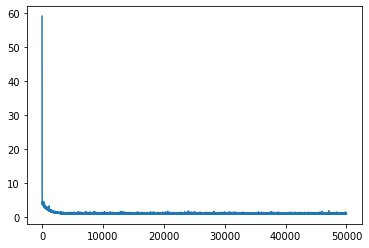

In [184]:
from tqdm.notebook import tqdm
#SGD with fixed learning rate

grad_jit = jax.jit(jax.grad(MSE, argnums = 2))
loss_jit = jax.jit(MSE)

np.random.seed(0)
max_epochs = 50000
learning_rate = 1e-3

params = np.random.randn(2)

history = [MSE(X,y,params)]

for epoch in tqdm(range(max_epochs)):

  index = np.random.choice(X.shape[0])
  g = grad_jit(X[index,:], y[index], params)
  #print(index)
  for i in range(len(params)):
    params[i] -= learning_rate * g[i]

  history.append(loss_jit(X,y,params))


print("loss: %1.2f" %(history[-1]))
plt.plot(history)
print(params)


In [186]:
history[-1]

DeviceArray(1.0007528, dtype=float32)